In [4]:
from functools import partial 
import jax
import jax.numpy as jnp 
import numpy as np 
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve
import matplotlib.pyplot as plt
import seaborn
from celluloid import Camera

In [5]:
rng = jax.random.PRNGKey(1)

In [6]:
def random_SSM(rng, N):
    a_r, b_r, c_r = jax.random.split(rng, 3)
    A = jax.random.uniform(a_r, (N, N))
    B = jax.random.uniform(b_r, (N, 1))
    C = jax.random.uniform(c_r, (1, N))
    return A, B, C


def discretize(A, B, C, step):
    I = np.eye(A.shape[0])
    BL = inv(I - (step / 2.0) * A)
    Ab = BL @ (I + (step / 2.0) * A)
    Bb = (BL * step) @ B
    return Ab, Bb, C

In [7]:
def scan_SSM(Ab, Bb, Cb, u, x0):
    def step(x_k_1, u_k):
        x_k = Ab @ x_k_1 + Bb @ u_k
        y_k = Cb @ x_k
        return x_k, y_k

    return jax.lax.scan(step, x0, u)

def run_SSM(A, B, C, u):
    L = u.shape[0]
    N = A.shape[0]
    Ab, Bb, Cb = discretize(A, B, C, step=1.0 / L)

    # Run recurrence
    return scan_SSM(Ab, Bb, Cb, u[:, np.newaxis], np.zeros((N,)))[1]

In [8]:
def example_mass(k, b, m):
    A = np.array([[0, 1], [-k / m, -b / m]])
    B = np.array([[0], [1.0 / m]])
    C = np.array([[1.0, 0]])
    return A, B, C

In [9]:
@partial(np.vectorize, signature="()->()")
def example_force(t):
    x = np.sin(10 * t)
    return x * (x > 0.5)

In [13]:
def example_ssm():
    # SSM
    ssm = example_mass(k=40, b=5, m=1)

    # L samples of u(t).
    L = 100
    step = 1.0 / L
    ks = np.arange(L)
    u = example_force(ks * step)

    # Approximation of y(t).
    y = run_SSM(*ssm, u)



    seaborn.set_context("paper")
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    camera = Camera(fig)
    ax1.set_title("Force $u_k$")
    ax2.set_title("Position $y_k$")
    ax3.set_title("Object")
    ax1.set_xticks([], [])
    ax2.set_xticks([], [])

    # Animate plot over time
    for k in range(0, L, 2):
        ax1.plot(ks[:k], u[:k], color="red")
        ax2.plot(ks[:k], y[:k], color="blue")
        ax3.boxplot(
            [[y[k, 0] - 0.04, y[k, 0], y[k, 0] + 0.04]],
            showcaps=False,
            whis=False,
            vert=False,
            widths=10,
        )
        camera.snap()
    anim = camera.animate()
    anim.save("line.gif", dpi=150, writer="imagemagick")

MovieWriter imagemagick unavailable; using Pillow instead.


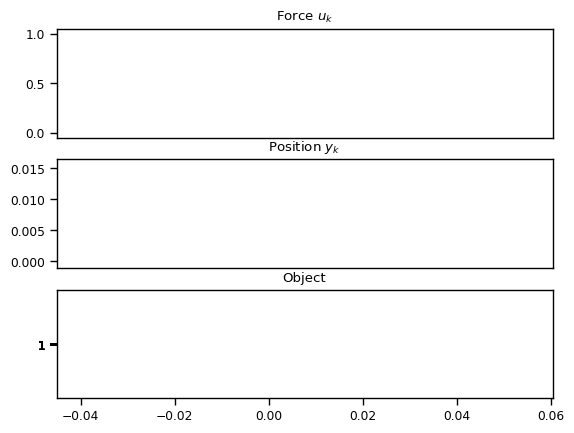

In [14]:

example_ssm()